# Competition

[Mercari Price Suggestion Challenge](https://www.kaggle.com/c/mercari-price-suggestion-challenge)

# Overview

メルカリに出品されている商品データ（カテゴリーやブランドなど）と価格をもとに<br>
商品データから価格を予測するモデルを作成する。

# Module

In [1]:
import gc
import sys
import optuna
import datetime
import warnings
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from pandas.api.types import is_categorical_dtype
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Unfreeze

Kaggleで用意されたデータが、7z形式になっているため<br>
解凍の処理から行っていく。

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/mercari-price-suggestion-challenge/train.tsv.7z
/kaggle/input/mercari-price-suggestion-challenge/test.tsv.7z
/kaggle/input/mercari-price-suggestion-challenge/sample_submission_stg2.csv.zip
/kaggle/input/mercari-price-suggestion-challenge/test_stg2.tsv.zip
/kaggle/input/mercari-price-suggestion-challenge/sample_submission.csv.7z


下記は、SettingsのInternetをONにして実行しないと、エラーになる。

In [3]:
!apt-get install p7zip
!p7zip -d -f -k /kaggle/input/mercari-price-suggestion-challenge/train.tsv.7z
!p7zip -d -f -k /kaggle/input/mercari-price-suggestion-challenge/test.tsv.7z
!p7zip -d -f -k /kaggle/input/mercari-price-suggestion-challenge/sample_submission.csv.7z




Suggested packages:
  p7zip-full
The following NEW packages will be installed:
  p7zip
0 upgraded, 1 newly installed, 0 to remove and 25 not upgraded.
Need to get 358 kB of archives.
After this operation, 996 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 p7zip amd64 16.02+dfsg-6 [358 kB]
Fetched 358 kB in 6s (62.0 kB/s)
debconf: delaying package configuration, since apt-utils is not installed
Selecting previously unselected package p7zip.
(Reading database ... 100572 files and directories currently installed.)
Preparing to unpack .../p7zip_16.02+dfsg-6_amd64.deb ...
Unpacking p7zip (16.02+dfsg-6) ...
Setting up p7zip (16.02+dfsg-6) ...

7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=C.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /kaggle/input/mercari-price-suggestion-challenge/

In [4]:
!unzip /kaggle/input/mercari-price-suggestion-challenge/sample_submission_stg2.csv.zip
!unzip /kaggle/input/mercari-price-suggestion-challenge/test_stg2.tsv.zip

Archive:  /kaggle/input/mercari-price-suggestion-challenge/sample_submission_stg2.csv.zip
  inflating: sample_submission_stg2.csv  
Archive:  /kaggle/input/mercari-price-suggestion-challenge/test_stg2.tsv.zip
  inflating: test_stg2.tsv           


# Datasets

In [5]:
train = pd.read_csv('train.tsv', sep='\t')

print(train.shape)
train.head(10)

(1482535, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity
5,5,Bundled items requested for Ruie,3,Women/Other/Other,NaN,59.0,0,"Banana republic bottoms, Candies skirt with ma..."
6,6,Acacia pacific tides santorini top,3,Women/Swimwear/Two-Piece,Acacia Swimwear,64.0,0,Size small but straps slightly shortened to fi...
7,7,Girls cheer and tumbling bundle of 7,3,Sports & Outdoors/Apparel/Girls,Soffe,6.0,1,You get three pairs of Sophie cheer shorts siz...
8,8,Girls Nike Pro shorts,3,Sports & Outdoors/Apparel/Girls,Nike,19.0,0,Girls Size small Plus green. Three shorts total.
9,9,Porcelain clown doll checker pants VTG,3,Vintage & Collectibles/Collectibles/Doll,NaN,8.0,0,I realized his pants are on backwards after th...


In [6]:
pd.DataFrame([['train_id', '商品ID'],
              ['name', '商品名'],
              ['item_condition_id', '商品の状態'],
              ['category_name', 'カテゴリー名'],
              ['brand_name', 'ブランド名'],
              ['price', '価格（単位：ドル）'],
              ['shipping', '送料が売手負担かどうか'],['item_description', '商品説明']],
              columns=['カラム', '意味'])

,カラム,意味
0,train_id,商品ID
1,name,商品名
2,item_condition_id,商品の状態
3,category_name,カテゴリー名
4,brand_name,ブランド名
5,price,価格（単位：ドル）
6,shipping,送料が売手負担かどうか
7,item_description,商品説明


testデータは、test.tsvとtest_stg2.tsvがある。<br>
submitのときには、test_stg2を使用する。

In [7]:
test_dummy = pd.read_csv('test.tsv', sep='\t')

print(test_dummy.shape)
test_dummy.head(10)

(693359, 7)


,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...
5,5,iPhone 6 Plus or 6s Plus Vodka pink case,1,"Electronics/Cell Phones & Accessories/Cases, C...",NaN,1,One Absolut Vodka in Pink for iPhone 6 Plus an...
6,6,Vintage Cameo Pendant & Brooch Pin,3,Women/Jewelry/Necklaces,Vintage,1,Two vintage Cameo pieces. 1. Silver metal Lock...
7,7,Rose Gold Stainless Steel Quartz Watch,1,Women/Women's Accessories/Watches,NaN,1,Brand new Price firm No trades Box included wi...
8,8,Daisy Marc Jacobs 3.4oz,3,Beauty/Fragrance/Women,MARC JACOBS,0,Brand new No box 100% authentic Firm price NO ...
9,9,Rose Brushes and Silicone Sponge,1,Beauty/Tools & Accessories/Makeup Brushes & Tools,NaN,1,All new. 12 pcs makeup brushes and one Silicon...


In [8]:
pd.DataFrame([['test_id', '商品ID'],
              ['name', '商品名'],
              ['item_condition_id', '商品の状態'],
              ['category_name', 'カテゴリー名'],
              ['brand_name', 'ブランド名'],
              ['shipping', '送料が売手負担かどうか'],['item_description', '商品説明']],
              columns=['カラム', '意味'])

,カラム,意味
0,test_id,商品ID
1,name,商品名
2,item_condition_id,商品の状態
3,category_name,カテゴリー名
4,brand_name,ブランド名
5,shipping,送料が売手負担かどうか
6,item_description,商品説明


In [9]:
test = pd.read_csv('test_stg2.tsv', sep='\t')

print(test.shape)
test.head(10)

(3460725, 7)


,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...
5,5,iPhone 6 Plus or 6s Plus Vodka pink case,1,"Electronics/Cell Phones & Accessories/Cases, C...",NaN,1,One Absolut Vodka in Pink for iPhone 6 Plus an...
6,6,Vintage Cameo Pendant & Brooch Pin,3,Women/Jewelry/Necklaces,Vintage,1,Two vintage Cameo pieces. 1. Silver metal Lock...
7,7,Rose Gold Stainless Steel Quartz Watch,1,Women/Women's Accessories/Watches,NaN,1,Brand new Price firm No trades Box included wi...
8,8,Daisy Marc Jacobs 3.4oz,3,Beauty/Fragrance/Women,MARC JACOBS,0,Brand new No box 100% authentic Firm price NO ...
9,9,Rose Brushes and Silicone Sponge,1,Beauty/Tools & Accessories/Makeup Brushes & Tools,NaN,1,All new. 12 pcs makeup brushes and one Silicon...


In [10]:
pd.DataFrame([['test_id', '商品ID'],
              ['name', '商品名'],
              ['item_condition_id', '商品の状態'],
              ['category_name', 'カテゴリー名'],
              ['brand_name', 'ブランド名'],
              ['shipping', '送料が売手負担かどうか'],['item_description', '商品説明']],
              columns=['カラム', '意味'])

,カラム,意味
0,test_id,商品ID
1,name,商品名
2,item_condition_id,商品の状態
3,category_name,カテゴリー名
4,brand_name,ブランド名
5,shipping,送料が売手負担かどうか
6,item_description,商品説明


In [11]:
del test_dummy
gc.collect()

135

# Analytics

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482531 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


In [13]:
train.nunique()

train_id             1482535
name                 1225273
item_condition_id          5
category_name           1287
brand_name              4809
price                    828
shipping                   2
item_description     1281426
dtype: int64

In [14]:
train.isnull().sum()

train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
dtype: int64

In [15]:
train.corr()

,train_id,item_condition_id,price,shipping
train_id,1.000000,-0.000113,0.000478,0.000472
item_condition_id,-0.000113,1.000000,-0.000807,-0.191154
price,0.000478,-0.000807,1.000000,-0.097211
shipping,0.000472,-0.191154,-0.097211,1.000000


<AxesSubplot:>

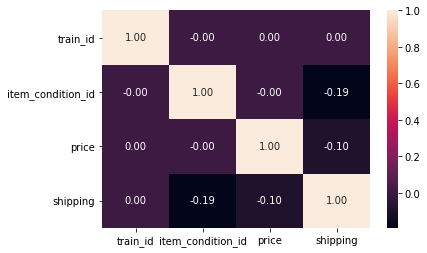

In [16]:
sns.heatmap(train.corr(), annot=True, fmt='.2f')

In [17]:
train.describe()

,train_id,item_condition_id,price,shipping
count,1.482535e+06,1.482535e+06,1.482535e+06,1.482535e+06
mean,7.412670e+05,1.907380e+00,2.673752e+01,4.472744e-01
std,4.279711e+05,9.031586e-01,3.858607e+01,4.972124e-01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,3.706335e+05,1.000000e+00,1.000000e+01,0.000000e+00
50%,7.412670e+05,2.000000e+00,1.700000e+01,0.000000e+00
75%,1.111900e+06,3.000000e+00,2.900000e+01,1.000000e+00
max,1.482534e+06,5.000000e+00,2.009000e+03,1.000000e+00


# Visualization

In [18]:
sns.set()

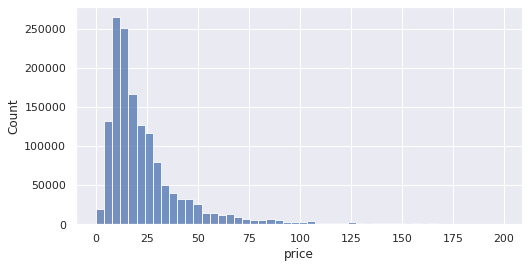

In [19]:
train = train.drop(train[(train['price'] >= 200)].index, axis=0)

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.histplot(train['price'], bins=50, ax=ax)
plt.show()

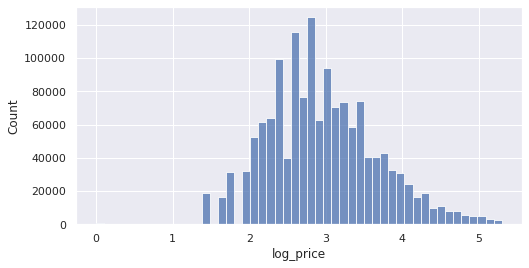

In [20]:
train['log_price'] = np.log1p(train['price'])

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.histplot(train['log_price'], bins=50, ax=ax)
plt.show()

In [21]:
train = train.drop('log_price', axis=1)
gc.collect()

6047

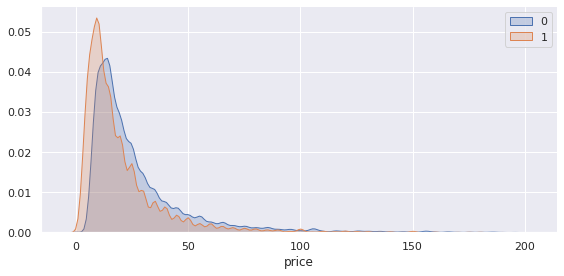

In [22]:
fig = sns.FacetGrid(train, hue='shipping', height=4, aspect=2)
fig.map(sns.kdeplot, 'price', shade=True)
plt.legend()

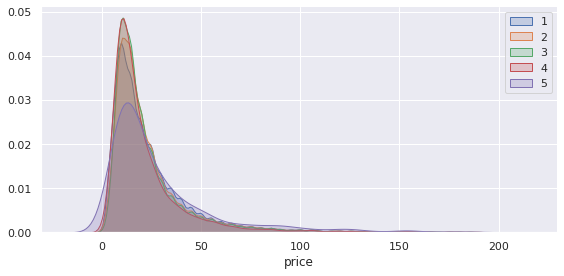

In [23]:
fig = sns.FacetGrid(train, hue='item_condition_id', height=4, aspect=2)
fig.map(sns.kdeplot, 'price', shade=True)
plt.legend()

# Preprocess

In [24]:
train_row = train.shape[0]
test_id = test['test_id']

In [25]:
target = np.log1p(train['price'])
train = train[[col for col in train.columns if col != 'price']]

In [26]:
train = train.drop('train_id', axis=1)
test = test.drop('test_id', axis=1)

In [27]:
X = pd.concat([train, test], axis=0)

print(X.shape)
X.head()

(4932413, 6)


,name,item_condition_id,category_name,brand_name,shipping,item_description
0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,1,No description yet
1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,0,This keyboard is in great condition and works ...
2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,1,Adorable top with a hint of lace and a key hol...
3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,1,New with tags. Leather horses. Retail for [rm]...
4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,0,Complete with certificate of authenticity


In [28]:
X.isnull().sum()

name                       0
item_condition_id          0
category_name          21115
brand_name           2107076
shipping                   0
item_description          10
dtype: int64

文字列を数値に変換するには、いくつかの方法がある。

・https://linus-mk.hatenablog.com/entry/pandas-unique-integer-id

また、数値変換を統一するために、trainとtestを結合して、まとめて実行する必要がある。

In [29]:
X['category_name'] = X['category_name'].fillna(value='missing')
X['item_description'] = X['item_description'].fillna(value='missing')
X['name'] = X['name'].fillna(value='missing')
X['brand_name'] = X['brand_name'].fillna(value='missing')

In [30]:
X['category_name'] = X['category_name'].astype('category')
X['item_description'] = X['item_description'].astype('category')
X['name'] = X['name'].astype('category')
X['brand_name'] = X['brand_name'].astype('category')

In [31]:
X['name'] = X['name'].cat.codes
X['category_name'] = X['category_name'].cat.codes
X['brand_name'] = X['brand_name'].cat.codes
X['item_description'] = X['item_description'].cat.codes

In [32]:
train = X[:train_row]
test = X[train_row:]

In [33]:
del train_row
gc.collect()

200

In [34]:
train = pd.concat([train, target], axis=1)

print(train.shape)
train.head()

(1471688, 7)


,name,item_condition_id,category_name,brand_name,shipping,item_description,price
0,1942987,3,864,6283,1,2590534,2.397895
1,2742268,3,87,4657,0,3506316,3.970292
2,279967,1,1320,5486,1,367558,2.397895
3,1702985,1,536,6283,1,2511534,3.583519
4,139326,1,1247,6283,0,1170787,3.806662


In [35]:
df_group = train.groupby('category_name')['price']

In [36]:
category_mean = df_group.mean()
category_median = df_group.median()
category_std = df_group.std()
category_min = df_group.min()
category_max = df_group.max()

In [37]:
train['category_mean'] = train['category_name'].map(category_mean)
train['category_median'] = train['category_name'].map(category_median)
train['category_std'] = train['category_name'].map(category_std)
train['category_min'] = train['category_name'].map(category_min)
train['category_max'] = train['category_name'].map(category_max)

In [38]:
del df_group
gc.collect()

20

In [39]:
train = train[[col for col in train.columns if col != 'price']]

In [40]:
train.to_pickle('train.pickle')

print(train.shape)
train.head()

(1471688, 11)


,name,item_condition_id,category_name,brand_name,shipping,item_description,category_mean,category_median,category_std,category_min,category_max
0,1942987,3,864,6283,1,2590534,2.770051,2.708050,0.563315,0.000000,5.283204
1,2742268,3,87,4657,0,3506316,3.274398,3.258097,0.797866,1.386294,5.278115
2,279967,1,1320,5486,1,367558,2.646088,2.564949,0.521971,0.000000,5.247024
3,1702985,1,536,6283,1,2511534,2.904655,2.833213,0.637105,0.000000,5.293305
4,139326,1,1247,6283,0,1170787,2.696821,2.484907,0.896413,0.000000,5.298317


In [41]:
print(target.shape)
target.head()

(1471688,)


0    2.397895
1    3.970292
2    2.397895
3    3.583519
4    3.806662
Name: price, dtype: float64

# Modeling

In [42]:
'''
X_tr, X_val, y_tr, y_val = train_test_split(train, target, test_size=0.2, random_state=666)

def create_model(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 3, 8)
    learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 0.99)
    subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)
    
    model = xgb.XGBRegressor(
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        random_state=666)
    return model

def objective(trial):
    model = create_model(trial)
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_val)
    rsme = np.sqrt(mean_squared_error(y_pred, y_val))
    return rsme

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=40)
params = study.best_params
print(params)
'''

"\nX_tr, X_val, y_tr, y_val = train_test_split(train, target, test_size=0.2, random_state=666)\n\ndef create_model(trial):\n    n_estimators = trial.suggest_int('n_estimators', 50, 500)\n    max_depth = trial.suggest_int('max_depth', 3, 8)\n    learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 0.99)\n    subsample = trial.suggest_uniform('subsample', 0.1, 1.0)\n    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)\n    \n    model = xgb.XGBRegressor(\n        n_estimators=n_estimators, \n        max_depth=max_depth, \n        learning_rate=learning_rate,\n        subsample=subsample,\n        colsample_bytree=colsample_bytree,\n        random_state=666)\n    return model\n\ndef objective(trial):\n    model = create_model(trial)\n    model.fit(X_tr, y_tr)\n    y_pred = model.predict(X_val)\n    rsme = np.sqrt(mean_squared_error(y_pred, y_val))\n    return rsme\n\nstudy = optuna.create_study(direction='minimize')\nstudy.optimize(objective, n_trials=40)\n

In [43]:
params = {'n_estimators': 223,
          'max_depth': 7,
          'learning_rate': 0.7251170417771181,
          'subsample': 0.646479352481374,
          'colsample_bytree': 0.8223733989305669,
          'random_state': 666}

In [44]:
cls = xgb.XGBRegressor(**params)
cls.fit(train, target)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8223733989305669, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.7251170417771181, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=223, n_jobs=2, num_parallel_tree=1, random_state=666,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=0.646479352481374, tree_method='exact',
             validate_parameters=1, verbosity=None)

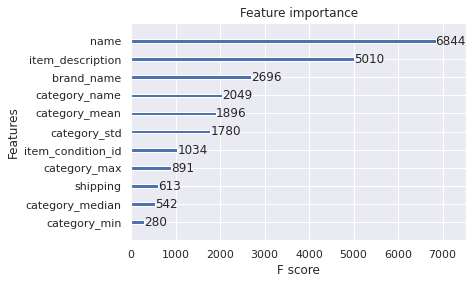

In [45]:
xgb.plot_importance(cls)
plt.show()

In [46]:
del train, target, params
gc.collect()

4569

# Submit

In [47]:
test['category_mean'] = test['category_name'].map(category_mean)
test['category_median'] = test['category_name'].map(category_median)
test['category_std'] = test['category_name'].map(category_std)
test['category_min'] = test['category_name'].map(category_min)
test['category_max'] = test['category_name'].map(category_max)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [48]:
test.to_pickle('test.pickle')

print(test.shape)
test.head()

(3460725, 11)


,name,item_condition_id,category_name,brand_name,shipping,item_description,category_mean,category_median,category_std,category_min,category_max
0,687992,1,1248,6283,1,3084753,2.866219,2.772589,0.829323,0.000000,5.298317
1,140679,1,934,6283,1,210147,2.345631,2.302585,0.525116,0.000000,5.225747
2,870054,1,1036,1298,1,845961,3.712730,3.713572,0.806799,0.000000,5.298317
3,1156281,2,1299,6283,0,74741,3.040210,2.890372,0.720912,0.000000,5.257495
4,1720115,3,895,6283,1,2909272,2.537237,2.484907,0.477239,1.386294,4.330733


In [49]:
prediction = np.expm1(cls.predict(test))

In [50]:
del test
gc.collect()

49

In [51]:
submit = pd.DataFrame(test_id, columns=['test_id'])
submit['price'] = prediction

submit.head(10)

,test_id,price
0,0,9.670785
1,1,6.734271
2,2,64.962723
3,3,11.789055
4,4,9.403168
5,5,9.568218
6,6,11.222969
7,7,12.780069
8,8,36.211502
9,9,14.101789


In [52]:
del test_id, prediction
gc.collect()

40

Submissionファイルは、/kaggle下ではなく、/kaggle/working下に作成する。<br>
また、submissionのCSVファイルについて、index=Falseにする。

In [53]:
submit.to_csv('./submission.csv', index=False)